# UrbanSound8K - Classification

**Objetivo:** Construir un modelo de Red Neuronales Convolucinales para predecir la clase a la que pertenece un dado sonido entre "air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "enginge_idling", "gun_shot", "jackhammer", "siren", y "street_music". 

## Marco Teórico

- **Espectograma:** Es una representación visual de la fuerza de una señal a través del tiempo permitiendo visualizar como las frecuencias terinan representandose en forma de onda. 
Los espectrogramas son básicamente gráficos bidimensionales, con una tercera dimensión representada por colores. El tiempo va de izquierda (más antiguo) a derecha (más joven) a lo largo del eje horizontal. El eje vertical representa la frecuencia, que también se puede considerar como tono, con las frecuencias más bajas en la parte inferior y las frecuencias más altas en la parte superior. La amplitud (o energía o "sonoridad") de una frecuencia particular en un momento particular está representada por la tercera dimensión, el color, con azules oscuros correspondientes a amplitudes bajas y colores más brillantes hasta el rojo correspondientes a amplitudes progresivamente más fuertes (o más fuertes).

- **Escala Mel:** Los estudios han demostrado que los humanos no perciben frecuencias en una escala lineal. Somos mejores para detectar diferencias en frecuencias más bajas que en frecuencias más altas. Por ejemplo, podemos distinguir fácilmente la diferencia entre 500 y 1000 Hz, pero difícilmente podremos notar una diferencia entre 10,000 y 10,500 Hz, aunque la distancia entre los dos pares sea la misma. 
En 1937, Stevens, Volkmann y Newmann propusieron una unidad de tono tal que distancias iguales en el tono sonaran igualmente distantes para el oyente. Esto se llama escala mel. Realizamos una operación matemática en frecuencias para convertirlas a la escala mel.

- **Espectrograma mel:** Es un espectrograma donde las frecuencias se convierten a la escala mel. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.utils.validation import column_or_1d
import gc
    
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.backend import clear_session

In [3]:
import os
import librosa
import librosa.display
import glob 
import skimage

Para cumplir nuestro objetivo tenemos un conjunto de datos que contiene 8,732 extractos de sonidos (de 4 o menos segundos), el conjunto está etiquetado según las clases ya mencionadas que se extraen de la taxonomía sonora urbana. 
Todos los extractos fueron obtenidos de https://www.kaggle.com/chrisfilo/urbansound8k. Los archivos se clasifican previamente en diez folds (carpetas denominadas fold1-fold10) para ayudar en la reproducción y comparación con los resultados de clasificación automática informados en el artículo anterior.

Además de los extractos de sonido, también se proporciona un archivo CSV que contiene metadatos sobre cada extracto, el cual será nuestra base para extraer la información.

Cargamos el csv de metadata.

In [4]:
df = pd.read_csv("urbansound8k/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


Empezamos visualizando los espectogramas de la información que vamos a utilizar, para lo cual obtenemos la serie de tiempo (que tiene la forma de un arreglo unidimensional flotante de Numpy) y también obtendremos la cantidad de muestras que tiene el registro por segundo de audio. Ésto lo obtendremos con librosa que es un paquete de python para análisis de música y audio.

In [5]:
dat1, sampling_rate1 = librosa.load('urbansound8k/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('urbansound8k/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Espectrograma lineal de frecuencias')

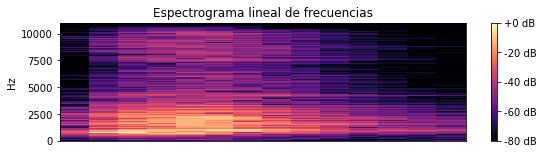

In [6]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma lineal de frecuencias')

Text(0.5, 1.0, 'Espectrograma lineal de frecuencias')

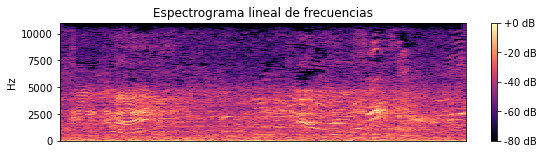

In [7]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma lineal de frecuencias')

Ahora vamos a visualizar un ejemplo de espectogramas con su respectiva etiqueta:

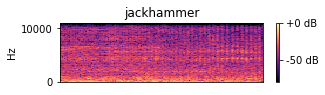

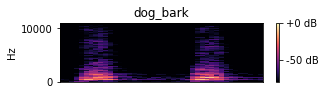

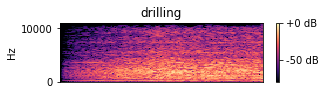

In [8]:
arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(192, 197, 2):
    path = 'urbansound8k/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

Lo siguiente que vamos a realizar es obtener del espectograma los Coeficientes cepstrales de frecuencia Mel. Lo cual será nuestra data dimensional.

In [9]:
dat1, sampling_rate1 = librosa.load('urbansound8k/fold5/100032-3-0-0.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1)
arr.shape

(128, 14)

## Extracción de características

Procedemos a crear el dataset que vamos a utilizar para el entranamiento, donde truncamos cada espectograma con la escala Mel a una forma de (128,14), si se encuentran registros que no cumplen con ello deberán ser removidos del dataset dependiendo de qué tantos sean. 

In [10]:
dataset = np.zeros((len(df),128,14))
input_dim = (128, 14,1)
label = []
fold = []
reg_out = []

for i in range(len(df)):
    file_name = 'urbansound8k/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mels = librosa.feature.melspectrogram(y=X, sr=sample_rate) 
    if mels.shape[1]>=14:
        mels = mels[:,0:14]
        #print(mels.shape)
        dataset[i] = mels
    else:
        reg_out.append(i)
    label.append(df["classID"][i])
    fold.append(df["fold"][i])

C:\Users\jose-\Anaconda3\envs\tensorflowGPU\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
C:\Users\jose-\Anaconda3\envs\tensorflowGPU\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
C:\Users\jose-\Anaconda3\envs\tensorflowGPU\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [11]:
print(len(reg_out),len(reg_out)/(len(df)/10))

69 0.07901969766376546


Antes de eliminar registros le damos la forma a la variable dependiente de acuerdo a "one hot encoding".

In [12]:
Y = to_categorical(label)

Puesto que son menos del 10% de los registros de una clase se toa la elección de remover dichos registros.

In [13]:
dataset2 = dataset.copy()
label2 = np.array(Y.copy())
fold2 = np.array(fold.copy())
dataset2 = np.delete(dataset2, reg_out, 0)
label2 = np.delete(label2, reg_out, 0)
fold2 = np.delete(fold2, reg_out, 0)

Construimos nuestra 'dict' con los 10 folds separando sus obseraviones x/y.

In [14]:
Folds_data = {}
K_Folds = set(fold2)

for i in K_Folds:
    #print(i,len(fold2[np.where(fold2==i)]))
    piv_len = len(dataset2[np.where(fold2==i)])
    np.random.seed(0)
    idx = np.random.randint(piv_len, size=piv_len//10)
    idx2 =  np.delete(range(piv_len), idx, 0)
    
    piv_train_x = dataset2[np.where(fold2==i)][idx2,:,:].reshape(-1, 128, 14, 1)
    piv_train_y = label2[np.where(fold2==i)][idx2,:]
    
    piv_test_x = dataset2[np.where(fold2==i)][idx,:,:].reshape(-1, 128, 14, 1)
    piv_test_y = label2[np.where(fold2==i)][idx,:]
    
    str_fold_x = 'X_train_' + str(i)
    str_fold_y = 'Y_train_' + str(i)    
    Folds_data[str_fold_x] = piv_train_x
    Folds_data[str_fold_y] = piv_train_y
    str_fold_x = 'X_test_' + str(i)
    str_fold_y = 'Y_test_' + str(i) 
    Folds_data[str_fold_x] = piv_test_x
    Folds_data[str_fold_y] = piv_test_y

Creamos una versión alterna de features para el entrenamiento.

In [15]:
dataset = np.zeros((len(df),128,1))
input_dim = (128, 14,1)
label = []
fold = []

for i in range(len(df)):
    file_name = 'urbansound8k/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate) )
    dataset[i] = mels
    label.append(df["classID"][i])
    fold.append(df["fold"][i])

Le damos la forma a la variable dependiente de acuerdo a "one hot encoding".

In [16]:
label = to_categorical(label)

Construimos nuestra 'dict' con los 10 folds separando sus obseraviones x/y.

In [17]:
Folds_data_v2 = {}
K_Folds = set(fold)

for i in K_Folds:
    #print(i,len(fold2[np.where(fold2==i)]))
    piv_len = len(dataset[np.where(fold==i)])
    np.random.seed(0)
    idx = np.random.randint(piv_len, size=piv_len//10)
    idx2 =  np.delete(range(piv_len), idx, 0)
    
    piv_train_x = dataset[np.where(fold==i)][idx2,:,:].reshape(-1, 16, 8, 1)
    piv_train_y = label[np.where(fold==i)][idx2,:]
    
    piv_test_x = dataset[np.where(fold==i)][idx,:,:].reshape(-1, 16, 8, 1)
    piv_test_y = label[np.where(fold==i)][idx,:]
    
    str_fold_x = 'X_train_' + str(i)
    str_fold_y = 'Y_train_' + str(i)    
    Folds_data_v2[str_fold_x] = piv_train_x
    Folds_data_v2[str_fold_y] = piv_train_y
    str_fold_x = 'X_test_' + str(i)
    str_fold_y = 'Y_test_' + str(i) 
    Folds_data_v2[str_fold_x] = piv_test_x
    Folds_data_v2[str_fold_y] = piv_test_y


## Entrenamiento

Para el entrenamiento haremos una red neuronal convolucional, para lo cual la iniciamos con la siguiente función, que devuelve un modelo con la topología siguiente:
- 1. Capa convolucional de 64 filtros de $3x3$ con la profundidad correspondiente.
- 2. Capa de Max Pooling para reducir a $1/4$ la dimensionalidad de los filtros obtenidos.
- 3. Capa convolucional de 128 filtros de $3x3$ con la profundidad correspondiente
- 4. Capa de Max Pooling para reducir a $1/4$ la dimensionalidad de los filtros obtenidos.
- 5. Capa de BatchNormalization.
- 6. Capa de Flatten para iniciar la red fully connected.
- 7. Capa densa de 1024 neuronas.
- 8. Capa de salida de 10 neuronas.

Compilamos la red con un optimizador 'adam' buscando optimizar la entropía cruzada y como métrica para la visualización  adicional la precisión del modelo.

In [18]:
def Create_Model1(input_dim):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding = "same", activation = "relu", input_shape = input_dim))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1024, activation = "tanh"))
    model.add(Dense(10, activation = "softmax"))
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_crossentropy','accuracy'])
    return model

In [19]:
model = Create_Model1(input_dim)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 14, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 7, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 7, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 3, 128)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 3, 128)        512       
_________________________________________________________________
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1

Creamos una segunda topología de Red Convolucional con la siguiente topología:
- 1. Capa convolucional de 32 filtros de $3x3$ con la profundidad correspondiente.
- 2. Capa de Max Pooling para reducir a $1/4$ la dimensionalidad de los filtros obtenidos.
- 3. Capa convolucional de 64 filtros de $3x3$ con la profundidad correspondiente
- 4. Capa de Max Pooling para reducir a $1/4$ la dimensionalidad de los filtros obtenidos.
- 3. Capa convolucional de 128 filtros de $3x3$ con la profundidad correspondiente
- 4. Capa de Max Pooling para reducir a $1/4$ la dimensionalidad de los filtros obtenidos.
- 5. Capa de BatchNormalization.
- 6. Capa de Flatten para iniciar la red fully connected.
- 7. Capa densa de 1024 neuronas.
- 8. Capa de salida de 10 neuronas.

In [20]:
def Create_Model2(input_dim):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding = "same", activation = "relu", input_shape = input_dim))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dense(10, activation = "softmax"))
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_crossentropy','accuracy'])
    return model

In [21]:
model = Create_Model2(input_dim)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 14, 32)       320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 7, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 7, 64)         18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 3, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 3, 128)        73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 1, 128)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 1, 128)       

Creamos el flujo de entrenamiento con validación cruzada.

In [22]:
if 'model' in globals():
    del model
Scores_Final = {}
def train(TipoF,Model,Epochs,BS):
    str_conf = 'F2'+str(TipoF) +'_'+'Model'+str(Model)+'_'+'Epochs' + str(Epochs)+'_'+ 'BS' +str(BS)
    Scores = []
    #Scores_ant = []
    tmp = datetime.now()
    for i in K_Folds:
        clear_session()
        if 'model' in locals():
            del model
        gc.collect()
        str_fold_x = 'X_train_' + str(i)
        str_fold_y = 'Y_train_' + str(i) 
        Y_train = np.zeros((1,10))
        if TipoF ==1:
            Folds_data_piv = Folds_data
            X_train = np.zeros((1,128,14,1))
            input_dim = (128, 14, 1)
        if TipoF ==2:
            Folds_data_piv = Folds_data_v2
            X_train = np.zeros((1,16,8,1))
            input_dim = (16, 8, 1)
        if Model == 1:
            model = Create_Model1(input_dim)
        if Model == 2:
            model = Create_Model2(input_dim)
        if Model == 3:
            model = Create_Model3(input_dim)
        #print(X_train.shape)
        X_val = Folds_data_piv[str_fold_x]
        Y_val = Folds_data_piv[str_fold_y]
        for j in K_Folds-set([i,i]):
            str_fold_x = 'X_train_' + str(j)
            str_fold_y = 'Y_train_' + str(j)
            X_train = np.append(X_train,Folds_data_piv[str_fold_x],axis=0)
            Y_train = np.append(Y_train,Folds_data_piv[str_fold_y],axis=0)
        X_train = np.delete(X_train, 0, 0)
        Y_train = np.delete(Y_train, 0, 0)
        #score = model.evaluate(X_val, Y_val)[2]
        #Scores_ant.append(score)
        model.fit(X_train, Y_train, epochs = Epochs, batch_size = BS, validation_data = (X_val, Y_val),steps_per_epoch=len(X_train)//BS,verbose = 0)
        score = model.evaluate(X_val, Y_val)[2]
        Scores.append(score)
        print(i,i/len(K_Folds),datetime.now() - tmp)
    Scores_Final[str_conf] = Scores

In [23]:
train(1,1,10,32)

781/781 [==============================] - 0s 174us/sample - loss: 2.3635 - categorical_crossentropy: 2.3635 - accuracy: 0.4814
1 0.1 0:00:39.843988


ResourceExhaustedError: OOM when allocating tensor with shape[12288,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: dense/kernel/Initializer/random_uniform/mul/

In [ ]:
train(1,1,30,50)

In [ ]:
train(1,1,90,50)

Comprobamos que no es la mejor topología y procedemos a cambiarla.

In [ ]:
train(1,2,10,50)

In [ ]:
train(1,2,30,50)

In [ ]:
train(1,2,90,50)

In [ ]:
train(2,1,10,50)

In [ ]:
train(2,1,30,50)

In [ ]:
train(2,1,90,50)

In [ ]:
train(2,2,10,50)

In [ ]:
train(2,2,30,50)

In [ ]:
train(2,2,90,50)

In [ ]:
Scores_Final

predictions = np.argmax(model.predict(X_val),axis=1)
real = np.argmax(Y_val,axis=1)

pd.crosstab(np.array(column_or_1d(predictions, warn=True)), np.array(column_or_1d(real, warn=True)), rownames = ['Pred'], colnames = ['Real'])